## prep

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [3]:
# read orginal file (dfrop max+not P)
ori_data = pd.read_excel("card transactions.xlsx", parse_dates=['Date'])
ori_data = ori_data.loc[(ori_data["Transtype"]=="P")]
ori_data = ori_data.loc[(ori_data["Amount"]!=ori_data["Amount"].max())]

In [4]:
cardnum = list(ori_data["Cardnum"])

In [5]:
# read variables file 
vars_data = pd.read_csv('after_feature_selection_forward_10.csv', parse_dates=['Date'])

In [6]:
vars_data["Cardnum"]=cardnum

In [7]:
final = vars_data.copy()

## train model

In [8]:
data = pd.read_csv('after_feature_selection_forward_10.csv', parse_dates=['Date'])

In [9]:
train_test = data[(data.Date >= '2010-01-15') & (data.Date <= '2010-10-31')].drop(columns=['Date'])
OOT = data[data.Date > '2010-10-31'].drop(columns=['Date'])

In [10]:
X = train_test.drop(columns=['Fraud', 'Amount'])
y = train_test['Fraud']
X_OOT = OOT.drop(columns=['Fraud', 'Amount'])
y_OOT = OOT['Fraud']

In [24]:
# Whether you want to resample or not
smote_flag = True

fdr_scores = pd.DataFrame(index=range(10), columns=['train fdr', 'test fdr', 'oot fdr'])
for i in range(10):
    # Use your own model and hyperparameters here
    model = model = MLPClassifier(hidden_layer_sizes=(20),
                      max_iter=400,
                      solver='adam',
                      activation='relu')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    X_OOT_scaled = pd.DataFrame(scaler.transform(X_OOT), columns=X_OOT.columns)
    
    #Capped 6
    drop_index = ((X_train_scaled >= 6) | (X_train_scaled <= -6)).sum(axis=1)
    drop_index = drop_index[drop_index >= 1].index.to_list()
    X_train_scaled = X_train_scaled.drop(index=drop_index)
    y_train = pd.DataFrame(y_train).iloc[X_train_scaled.index, :]['Fraud']
    
    if smote_flag:
        y_neg_cnt = (y_train == 0).sum()
        smote = SMOTE(sampling_strategy={0: y_neg_cnt, 1: int(y_neg_cnt/10)})
        X_train_smo, y_train_smo = smote.fit_sample(X_train_scaled, y_train)
        model.fit(X_train_smo, y_train_smo)
    else:
        model.fit(X_train_scaled, y_train)

In [25]:
predict_data_scaled = pd.DataFrame(scaler.transform(final.iloc[:,0:10]), columns=final.iloc[:,0:10].columns)

## assign fraud score

In [26]:
fraud_score = model.predict_proba(predict_data_scaled)[:,1]
final['Fraud Score']=fraud_score.round(5)

In [27]:
final.head()

,total_Amount_card_description_7,total_Amount_card_description_3,max_Amount_card_state_14,total_Amount_Cardnum_3,total_Amount_card_description_1,total_Amount_Cardnum_0,total_Amount_card_description_0,total_Amount_Cardnum_14,max_Amount_card_state_30,max_Amount_Cardnum_3,Date,Fraud,Amount,Cardnum,Fraud Score
0,293.22,293.22,3.67,438.57,293.22,438.57,293.22,438.57,3.67,3.67,2010-01-01,0,3.62,5142190439,0.00179
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2010-01-01,0,31.42,5142183973,0.00170
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,2010-01-01,0,178.49,5142131721,0.00344
3,93.20,93.20,3.80,182.84,93.20,182.84,93.20,182.84,3.80,3.80,2010-01-01,0,3.62,5142148452,0.00135
4,293.22,293.22,3.67,438.57,293.22,438.57,293.22,438.57,3.67,3.67,2010-01-01,0,3.62,5142190439,0.00179


## plot cardnumber

In [28]:
card = final[["Date","Cardnum","Fraud Score"]].loc[(final["Cardnum"]==5142235211)]
card["Count"]=list(range(1, len(card)+1))
card.head()

,Date,Cardnum,Fraud Score,Count
16216,2010-03-07,5142235211,0.10592,1
16323,2010-03-07,5142235211,0.13628,2
16568,2010-03-07,5142235211,0.12888,3
16575,2010-03-07,5142235211,0.10592,4
16928,2010-03-08,5142235211,0.00194,5


In [29]:
cardnum_date = card.loc[card["Date"]>="2010-07-01"].loc[card["Date"]<="2010-12-31"].sort_values(by='Date')

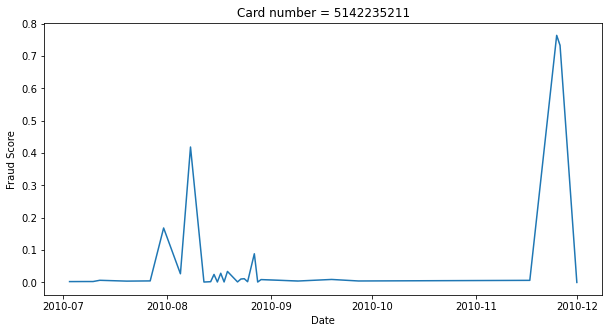

In [30]:
plt.figure(figsize=(10,5))
sns.lineplot(x=cardnum_date["Date"], y=cardnum_date["Fraud Score"], ci=0)
plt.title("Card number = 5142235211")
plt.savefig("cardnum_date.png", transparent=True)

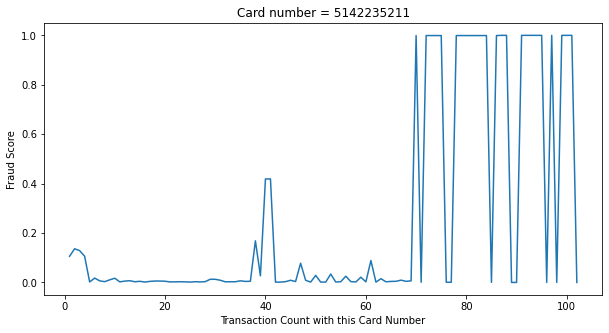

In [31]:
plt.figure(figsize=(10,5))
sns.lineplot(x=card["Count"], y=card["Fraud Score"])
plt.title("Card number = 5142235211")
plt.xlabel("Transaction Count with this Card Number")
plt.savefig("cardnum_count.png", transparent=True)

In [19]:
card.sort_values(by=["Fraud Score","Count"], ascending=[False,True])

,Date,Cardnum,Fraud Score,Count
89082,2010-11-26,5142235211,1.0,87
89083,2010-11-26,5142235211,1.0,88
89114,2010-11-26,5142235211,1.0,91
89117,2010-11-26,5142235211,1.0,92
89120,2010-11-26,5142235211,1.0,93
...,...,...,...,...
89091,2010-11-26,5142235211,0.0,89
89112,2010-11-26,5142235211,0.0,90
89129,2010-11-26,5142235211,0.0,96
89134,2010-11-26,5142235211,0.0,98
